## Assignment 3

### Part A3.1: Access PMU from python

* http://neocontra.blogspot.com/2013/05/user-mode-performance-counters-for.html
* https://www.cprogramming.com/tutorial/shared-libraries-linux-gcc.html
*https://stackoverflow.com/questions/3247373/how-to-measure-program-execution-time-in-arm-cortex-a8-processor/3250835#3250835

In [131]:
import ctypes

## # Import shared library

In [132]:
_libInC = ctypes.CDLL('./libPMULib.so')

In [122]:
counter = _libInC.my_init_counters(1,0)
print(counter)

1


In [123]:
a = _libInC.my_get_cyclecount()
print(a)

-1537362712


### Part A3.2: Comparing and Gathering Data

In [133]:
import multiprocessing
import os
import time
import numpy as np
import math
import matplotlib.pyplot as plot
import statistics as stats

In [134]:
SUCCESS = 0
FAILURE = -1
CPU_FHz = 650e6
EN_DIV_COUNT = 29
NUM_TRIAL = 3

#### Standard error : The formula for standard deviation calculates the square root of the variance, while the 
formula for standard error calculates the standard deviation divided by the square root of the sample size.

In [135]:
class DataMetricsMngr:
    num_terms = 0
    term_iteration = 0
    cpu_cycle_time_list    = []
    cpu_cycle_time_mean    = []
    cpu_cycle_time_std_dev = []
    cpu_cycle_time_std_err = []
    python_time_list       = []
    python_time_mean       = []
    python_time_std_dev    = []
    python_time_std_err    = []
    
    def __init__(self, numCount, numIteration):
        self.num_terms          = numCount
        self.term_iteration     = numIteration
        for i in range(numCount):          # A for loop for row entries
            a =[]
            for j in range(numIteration):      # A for loop for column entries
                a.append(0)
            self.cpu_cycle_time_list.append(a)
            self.python_time_list.append(a)
            self.cpu_cycle_time_mean.append(0)
            self.cpu_cycle_time_std_dev.append(0)
            self.cpu_cycle_time_std_err.append(0)
            self.python_time_mean.append(0)
            self.python_time_std_dev.append(0)
            self.python_time_std_err.append(0)
        print(len(self.cpu_cycle_time_list))
                
    def DataMetricsMngr_update_cpu_cycle_time_list(self,_index, cpu_cycle_time, num_iteration):
        self.cpu_cycle_time_list[_index][num_iteration] = cpu_cycle_time
        
    def DataMetricsMngr_update_python_time_list(self, _index, cpu_cycle_time, num_iteration):
        self.python_time_list[_index][num_iteration] = cpu_cycle_time
    
    def DataMetricsMngr_update_cpu_cycle_time_mean(self, _index):
        self.cpu_cycle_time_mean[_index] = stats.mean(self.cpu_cycle_time_list[_index])
        print("Cpu Mean for {} = {}".format(_index, self.cpu_cycle_time_mean[_index]))
    
    def DataMetricsMngr_update_python_time_mean(self, _index):
        self.python_time_mean[_index] = stats.mean(self.python_time_list[_index])
        print("Python Mean for {} = {}".format(_index, self.python_time_mean[_index]))
    
    def DataMetricsMngr_update_cpu_cycle_time_std_err(self, _index):
        #first find std dev
        self.cpu_cycle_time_std_dev[_index] = stats.stdev(self.cpu_cycle_time_list[_index], self.cpu_cycle_time_mean[_index])
        #find standard error
        self.cpu_cycle_time_std_err[_index] = self.cpu_cycle_time_std_dev[_index] / math.sqrt(self.term_iteration)
        print("CPU Standard error for index {} is {}".format(_index, self.cpu_cycle_time_std_err[_index]))
        
    def DataMetricsMngr_update_python_time_std_err(self, _index):
         #first find std dev
        self.python_time_std_dev[_index] = stats.stdev(self.python_time_list[_index], self.python_time_mean[_index])
        #find standard error
        self.python_time_std_err[_index] = self.python_time_std_dev[_index] / math.sqrt(self.term_iteration)
        print("Python Standard error for index {} is {}".format(_index, self.cpu_cycle_time_std_err[_index]))
        
    def DataMetricsMngr_plot_cpu_cycle_metrics(self):
        x = []
        for i in range(self.num_terms):
            x.append(i+1)
            
        plot.errorbar(x, self.cpu_cycle_time_mean, self.cpu_cycle_time_std_err, linestyle='solid', marker='^')
        plot.title("Plot of average cpu cycle time with error bars")
        plot.xlabel("Fibonacci Numbers")
        plot.ylabel("Average time with error")
        plot.show()
    
    def DataMetricsMngr_plot_python_cycle_metrics(self):
        x = []
        for i in range(self.num_terms):
            x.append(i+1)
            
        plot.errorbar(x, self.python_time_mean, self.python_time_std_err, linestyle='solid', marker='^')
        plot.title("Plot of average Python time with error bars")
        plot.xlabel("Fibonacci Numbers")
        plot.ylabel("Average time with error")
        plot.show()
    
    

In [136]:
# Program to calculate the Fibonacci sequence up to n-th term
def recur_fibo(n):
    if n <= 1:
        return n
    else:
        return(recur_fibo(n-1) + recur_fibo(n-2))

In [137]:
def performance_metrics_calculator(_id, num_fib, b_reset, b_divide, num_iter, _mgnr):
    #Assign the process to specific CPU
    os.system("taskset -pc {} {}".format(_id,os.getpid()))
    print(hex(id(_mgnr)))
    print("Fibonacci Series for num {}".format(num_fib))
    print("Reset {} Divide{}".format(b_reset, b_divide))
    MULT = 1
    if b_divide == True:
        MULT = 64
    i = 0
    while i <  num_iter:
        #init timers
        _libInC.my_init_counters(1, 0);
    
        #take python module time
        tic = time.time()
    
        #get cycle count
        cpu_time1 = MULT* ctypes.c_uint32(_libInC.my_get_cyclecount()).value
    
        # Run recur fib program
        recur_fibo(num_fib)
    
        #get 2nd cycle count 
        cpu_time2 = MULT* ctypes.c_uint32(_libInC.my_get_cyclecount()).value
    
        #get 2nd timer
        tac = time.time()
    
        time_cycleCount = (cpu_time2-cpu_time1)/CPU_FHz
        python_time = tac - tic
        print("Trial {}".format(i+1))
        print("Timer module value ={} ".format(tac-tic))
        print("Cycle count value = {}".format(time_cycleCount))
        _mgnr.DataMetricsMngr_update_cpu_cycle_time_list(num_fib-1,time_cycleCount,i)
        _mgnr.DataMetricsMngr_update_python_time_list(num_fib-1,python_time,i)
        i +=1

In [138]:
def main():
    nterms = int(input("Enter terms till which Fibonacci series is to be generated? "))
    # check if the number of terms is valid
    if nterms <= 0:
        print("Please enter a positive integer")
        return FAILURE
    
    cpu_id = int(input("Enter CPU ID(0/1) for CPU selection"))
    print("CPU ID Entered = ", cpu_id)
    # check if cpu id is valid
    if cpu_id < 0 or cpu_id > 1:
        print("unsupported CPU id Entered")
        return FAILURE
    i = 1
    num_iteration = NUM_TRIAL
    metricsMngr = DataMetricsMngr(nterms, num_iteration)
    print(hex(id(metricsMngr)))
    while i <= nterms:
        do_reset = True
        do_divide = False
        if i > EN_DIV_COUNT:
            do_divide = True
        # create a process
        p1 = multiprocessing.Process(target=performance_metrics_calculator, args=(cpu_id,i,do_reset, do_divide, num_iteration, metricsMngr)) # the first arg defines which CPU to run the 'target' on
        # start the process
        p1.start() 
        p1Name = p1.name # get process1 name
        p1.join() # wait for process1 to finish
        
        metricsMngr.DataMetricsMngr_update_cpu_cycle_time_mean(i-1)
        metricsMngr.DataMetricsMngr_update_python_time_mean(i-1)
        metricsMngr.DataMetricsMngr_update_cpu_cycle_time_std_err(i-1)
        metricsMngr.DataMetricsMngr_update_python_time_std_err(i-1)
        i +=1
        print('Process with name, {}, is finished'.format(p1Name))
    metricsMngr.DataMetricsMngr_plot_cpu_cycle_metrics()
    metricsMngr.DataMetricsMngr_plot_python_cycle_metrics()

### Main function to handle input and spawn separate process

Enter terms till which Fibonacci series is to be generated? 35
Enter CPU ID(0/1) for CPU selection0
CPU ID Entered =  0
35
0xaefbee50
0xaefbee50
Fibonacci Series for num 1
Reset True DivideFalse
Trial 1
Timer module value =0.00033593177795410156 
Cycle count value = 0.0001463353846153846
Trial 2
Timer module value =6.031990051269531e-05 
Cycle count value = 3.163076923076923e-05
Trial 3
Timer module value =5.793571472167969e-05 
Cycle count value = 2.9715384615384615e-05
Cpu Mean for 0 = 0
Python Mean for 0 = 0
CPU Standard error for index 0 is 0.0
Python Standard error for index 0 is 0.0
Process with name, Process-112, is finished
0xaefbee50
Fibonacci Series for num 2
Reset True DivideFalse
Trial 1
Timer module value =0.0003800392150878906 
Cycle count value = 0.00018418153846153846
Trial 2
Timer module value =6.389617919921875e-05 
Cycle count value = 3.5566153846153845e-05
Trial 3
Timer module value =6.270408630371094e-05 
Cycle count value = 3.434923076923077e-05
Cpu Mean for 1 = 0

Fibonacci Series for num 17
Reset True DivideFalse
Trial 1
Timer module value =0.007707357406616211 
Cycle count value = 0.00751328923076923
Trial 2
Timer module value =0.007441282272338867 
Cycle count value = 0.0073925584615384616
Trial 3
Timer module value =0.007288217544555664 
Cycle count value = 0.0072393523076923075
Cpu Mean for 16 = 0
Python Mean for 16 = 0
CPU Standard error for index 16 is 0.0
Python Standard error for index 16 is 0.0
Process with name, Process-128, is finished
0xaefbee50
Fibonacci Series for num 18
Reset True DivideFalse
Trial 1
Timer module value =0.012243032455444336 
Cycle count value = 0.012056581538461538
Trial 2
Timer module value =0.011797666549682617 
Cycle count value = 0.011751610769230768
Trial 3
Timer module value =0.01183462142944336 
Cycle count value = 0.011787632307692308
Cpu Mean for 17 = 0
Python Mean for 17 = 0
CPU Standard error for index 17 is 0.0
Python Standard error for index 17 is 0.0
Process with name, Process-129, is finished
0xaef

0xaefbee50
Fibonacci Series for num 34
Reset True DivideTrue
Trial 1
Timer module value =25.16632342338562 
Cycle count value = 341.95649496615385
Trial 2
Timer module value =25.21062469482422 
Cycle count value = 344.79555771076923
Trial 3
Timer module value =25.19917583465576 
Cycle count value = 344.06289851076923
Cpu Mean for 33 = 0
Python Mean for 33 = 0
CPU Standard error for index 33 is 0.0
Python Standard error for index 33 is 0.0
Process with name, Process-145, is finished
0xaefbee50
Fibonacci Series for num 35
Reset True DivideTrue
Trial 1
Timer module value =40.62126111984253 
Cycle count value = 62.389586904615385
Trial 2
Timer module value =40.690314292907715 
Cycle count value = 66.82193939692307
Trial 3
Timer module value =40.705320596694946 
Cycle count value = 67.78248664615384
Cpu Mean for 34 = 0
Python Mean for 34 = 0
CPU Standard error for index 34 is 0.0
Python Standard error for index 34 is 0.0
Process with name, Process-146, is finished


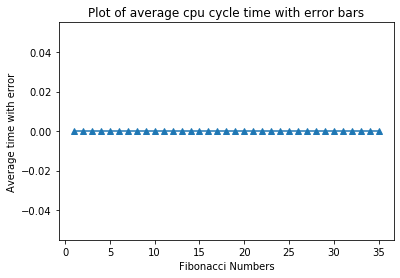

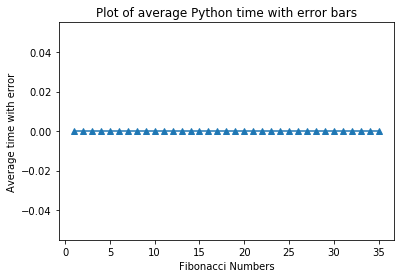

Program exited successfully


In [139]:
if __name__ == '__main__':
    result = main()
    if result == FAILURE:
        print("Program exited, exit code = FAILURE")
    else:
        print("Program exited successfully")